<hr>
<br><br><br>
<div align=center>
<font size=2>
        Trabalho de Conclusão de Curso
    </font>
    <br><br><BR>
    <font size=3>
        Classificação de sentimento em arquivos de áudio<br>a partir da extração de Coeficientes Cepstrais na frequência Mel<br>(MFCCs)
    </font>
    <br><br><BR>
    <font size=2>
        ICMC-USP
    </font>    
</div>
<br><br><br>
<hr>

Principais atividades do notebook:
- Carregamento da base de dados
- Extração de features
- Tratamento de features
- Gravação da base da dados preparada

<br><br>
<a id=menu></a>

[Biblotecas](#libs) <br>
[Dados](#data) <br>
[Pré-processamento](#prep) <br>

<br>

<a id='libs'></a>
<h3>Bibliotecas</h3>
<br>
<blockquote>
    <dl>
        <dl>- keras: interface para desenvolvimento de redes neurais.</dl>
        <dl>- librosa: múltiplas funcionalidades para tratamento de arquivos de áudio.</dl>
        <dl>- Matplotlib: criação de gráficos e visuadlzação de dados.</dl>
        <dl>- Numpy: processamento de vetores e matrizes multimensionais.</dl>
        <dl>- Pandas: manipulação e análise de dados tabulares e séries temporais</dl>
        <dl>- Seaborn: criação de gráficos e visualização de dados.</dl>
        <dl>- Sklearn: algoritmos de aprendizado de máquina.</dl>
    </dl>
</blockquote>


In [558]:
import librosa as ls
import numpy as np 
import pandas as pd 
import IPython.display as play


from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
import seaborn as sns

import os
from tqdm import tqdm 

In [559]:
### Set visual features to pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

<br>
<a id='data'></a>
<h3>Dados</h3>

<font size=1>[menu](#menu)</font>

Lista os caminhos de referência dos arquivos de áudio na pasta de origem para posterior leitura e extração de features.

In [560]:
# Getting file paths
files_list = []
for dirname, _, filenames in os.walk('../data/ravdess'):
    for filename in filenames:
        files_list.append(os.path.join(dirname, filename))

print(f'Total files: {len(files_list)}')

Total files: 1441


Filtra a lista de arquivos a fim de garantir que tenham formatos de áudio válidos e compatíveis à leitura da biblioteca de extração de features `librosa`.

In [561]:
### Search just for wav or mp3 files
files_list = [file for file in files_list if  '.wav' in file or '.mp3' in file]

Cria dicionário para mapeamento das classes de sentimentos existentes na base de dados.

In [562]:
emotions_dict = {'01' : 'neutral', 
                '02' : 'calm' ,
                '03' : 'happy' ,
                '04' : 'sad' ,
                '05' : 'angry', 
                '06' : 'fearful' ,
                '07' : 'disgust', 
                '08' : 'surprised'}

Executa seleção randômica de arquivos da base de dados e extrai informações para visualização.

In [563]:
### Set number of samples to visualize
n_samples = 12

np.random.seed(31)
samples = []
for n in tqdm(range(n_samples)):
    random_file_idx = np.random.randint(0, len(files_list))
    audio,sfreq = ls.load(files_list[random_file_idx])
    time = np.arange(0,len(audio))/sfreq
    actor = files_list[random_file_idx].split("/")[-2]
    emotion = emotions_dict[files_list[random_file_idx].split("-")[2]]
    samples.append((emotion, actor, time, audio))


100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


Gera visualização dos arquivos de áudio selecionados randomicamente acima.
- Título: ator e sentimento 
- Eixo x: duração do sinal
- Eixo y: amplitude do sinal

100%|██████████| 12/12 [00:00<00:00, 94.17it/s] 


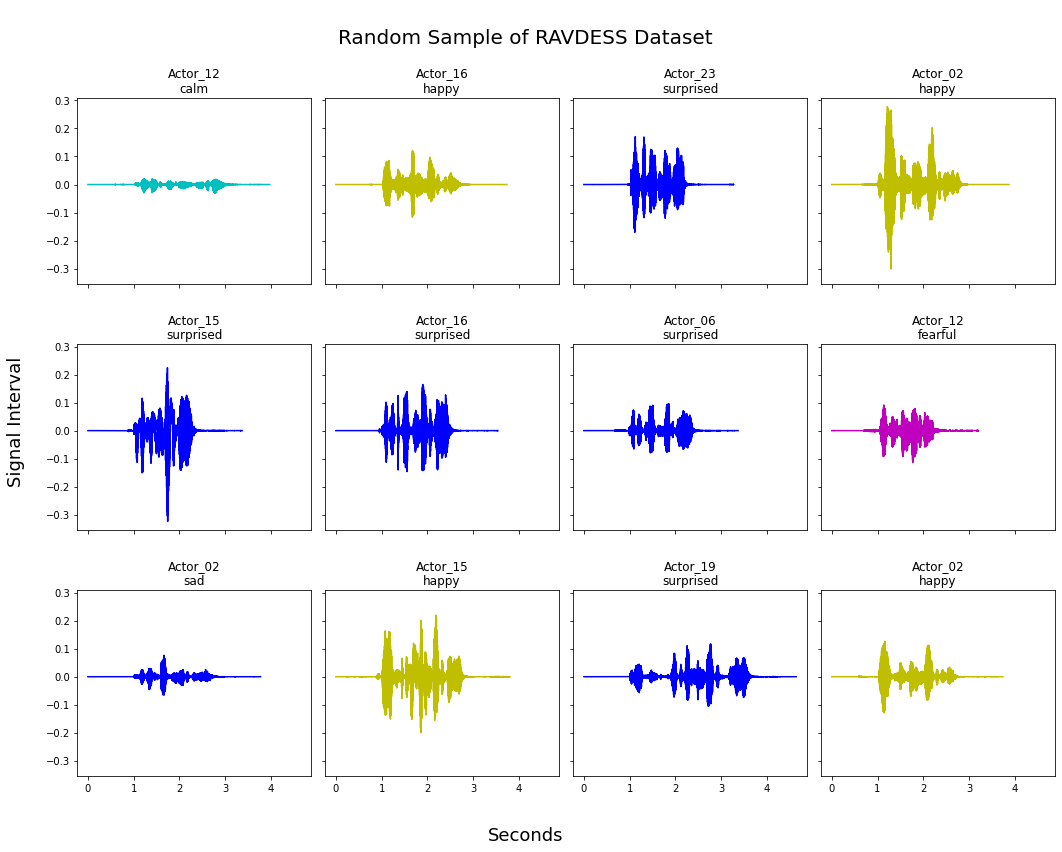

In [564]:
### Visualize above extracted samples
### note: rows * columns result musn't
### be less than total of samples

rows = 3
columns = 4

fig, ax = plt.subplots(nrows=rows, ncols=columns, sharex=True, sharey=True, figsize=(rows*5,rows*4))
ax = ax.ravel()

colors_dict = {'neutral': 'w', 
                'calm':'c',
                'happy': 'y',
                'sad':'b',
                'angry':'r', 
                'fearful':'m',
                'disgust':'g', 
                'surprised':'b'}

for i in tqdm(range(len(samples))):
    ax[i].plot(samples[i][2],samples[i][3], colors_dict.get(samples[i][0]))
    ax[i].set_title(f'\n{samples[i][1]}\n{samples[i][0]}')

fig.suptitle('\nRandom Sample of RAVDESS Dataset', fontsize=20)
fig.supxlabel('\nSeconds', fontsize=18)
fig.supylabel('Signal Interval\n', fontsize=18)
fig.tight_layout()

Gera audição de áudio selecionado randomicamente e exibido na vizualição acima.

In [565]:
### Player can fail in VSCode

### Set sample
audio_sample = 0
print(f'\n{samples[audio_sample][1]}\n{samples[audio_sample][0].upper()}')
play.Audio(samples[audio_sample][3], rate=22050)


Actor_12
CALM


<br>
<a id='prep'></a>
<h3>Pré-processamento</h3>

<font size=1>[menu](#menu)</font>

Método para extração de features.

In [566]:

def extract_feature(file_name, mfcc, chroma, mel, centroid=False):
        
        result=np.array([])
        X,sample_rate = ls.load(file_name)

        if mfcc:
            mfccs=np.mean(ls.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if mel:
            mel=np.mean(ls.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if chroma:
            stft=np.abs(ls.stft(X))
            chroma=np.mean(ls.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
            if centroid:
                cntr=np.mean(ls.feature.spectral_centroid(S=stft, sr=sample_rate).T,axis=0)
                result=np.hstack((result, cntr))

        return result

Extrai 

In [567]:
### Extract features from files
### and get associated emotion

features, emotions = [],[]
extract_log = {}

for file in tqdm(files_list):
        feature = extract_feature(file, mfcc=True, mel=True, chroma=True, centroid=True)
        emotion = emotions_dict[file.split("-")[2]]

        features.append(feature)
        emotions.append(emotion)

        actor = file.split('/')[-2]
        extract_log[actor] = emotion


100%|██████████| 1440/1440 [07:10<00:00,  3.34it/s]


- 40 features correspondem aos mfccs
- 128 feataures correspondem ao espectograma da escala mel
- 12 features correspondem ao cromagrama
- 1 feature corresponde ao centróide espectral
- 1 feature corresponde à classe do sentimento


In [568]:
# Create dataset
df = pd.concat([pd.DataFrame(features), pd.DataFrame({'emotion':emotions})], axis=1)
print(df.shape)
df.head(3)

(1440, 182)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,emotion
0,-542.476074,34.173908,-4.178416,3.481093,-10.056520,-5.639079,-9.015796,-11.046254,-11.980909,-0.922416,-7.606282,-5.592604,-3.499023,-5.074188,-6.419102,-5.122108,-2.608755,-6.661537,-6.285834,-2.091156,-4.906449,0.095155,-2.598092,0.609326,-4.013554,-0.970240,-1.825634,-1.876157,1.186396,4.084438,3.416614,3.990882,-0.816124,1.228920,-0.475947,3.193812,0.286677,2.349774,-1.145714,2.378389,0.000019,0.000092,0.000151,0.000136,0.000907,0.015207,0.042250,0.256988,0.517432,0.130183,0.119377,0.395089,0.180228,0.078284,0.076138,0.271303,0.464707,0.398115,0.398021,0.156770,0.126383,0.306210,0.516909,0.477038,0.135612,0.218012,0.250903,0.365548,0.453583,0.159773,0.072200,0.158748,0.150159,0.102213,0.222884,0.269868,0.223530,0.206060,0.028564,0.029148,0.017117,0.058709,0.086702,0.044761,0.068444,0.099534,0.139136,0.048969,0.034514,0.068664,0.186554,0.115396,0.055746,0.014237,0.006917,0.013889,0.015000,0.035244,0.032238,0.009730,0.007119,0.015159,0.014026,0.012896,0.003669,0.006452,0.007503,0.028949,0.006422,0.004420,0.016153,0.024440,0.010665,0.002379,0.005927,0.004943,0.005220,0.007214,0.012885,0.018005,0.025372,0.036288,0.047307,0.043949,0.082535,0.040218,0.020004,0.017704,0.015276,0.012228,0.007650,0.006640,0.003383,0.002900,0.001512,0.001309,0.002348,0.001750,0.002402,0.001617,0.001259,0.001024,0.000945,0.001895,0.000951,0.001134,0.002001,0.002936,0.005151,0.007798,0.007249,0.005720,0.003260,0.003891,0.004343,0.006763,0.008217,0.011161,0.008156,0.004279,0.002586,0.003110,0.002963,0.003668,0.003789,0.002758,0.001566,0.000067,0.555700,0.515436,0.534440,0.576345,0.547919,0.583930,0.539773,0.539510,0.592600,0.604869,0.615869,0.599911,3000.496656,angry
1,-551.025146,37.591530,-6.325912,5.090826,-2.366514,-9.050036,-14.804225,-13.916537,-8.760804,1.099795,-12.927682,-7.508514,1.207623,-6.401278,-6.351036,-3.981414,-5.936777,-2.827255,-4.569509,-4.028167,-0.476367,0.991257,1.736354,4.328723,0.802083,6.011786,0.159741,1.832495,-0.302476,-0.186748,-0.635078,0.723791,-1.399950,0.931257,-1.221707,1.392579,-0.495146,1.612840,-0.553441,0.980045,0.000027,0.000039,0.000053,0.000065,0.000392,0.004423,0.041761,0.167385,0.292937,0.688341,0.518451,0.237308,0.189039,0.178225,0.093688,0.047789,0.051415,0.128913,0.259472,0.349795,1.371628,0.868671,0.261380,0.131455,0.045773,0.058029,0.045455,0.018238,0.020625,0.011886,0.030236,0.062897,0.042935,0.046116,0.015668,0.005795,0.005947,0.005185,0.002529,0.002147,0.002757,0.006300,0.005228,0.002868,0.002849,0.002577,0.003207,0.003490,0.005509,0.005538,0.006525,0.004654,0.005974,0.004369,0.004734,0.002827,0.001869,0.002422,0.004437,0.005850,0.004500,0.004057,0.003421,0.002263,0.002572,0.002393,0.002878,0.001806,0.000523,0.000349,0.001139,0.003251,0.001028,0.000466,0.001047,0.002191,0.003479,0.000824,0.001621,0.001095,0.000455,0.000428,0.000540,0.001034,0.000572,0.000943,0.000738,0.000577,0.000539,0.000445,0.000637,0.000943,0.001563,0.001220,0.000677,0.000279,0.000158,0.000147,0.000105,0.000159,0.000268,0.000384,0.000576,0.000781,0.000910,0.000959,0.000821,0.000907,0.001016,0.001323,0.001069,0.001051,0.001545,0.003160,0.002883,0.004131,0.005552,0.004003,0.002548,0.001828,0.002075,0.002708,0.002218,0.002085,0.001779,0.001477,0.000548,0.000035,0.550358,0.507950,0.477042,0.458502,0.408957,0.407329,0.406826,0.425900,0.472114,0.543731,0.561210,0.558470,2674.064395,fearful
2,-390.723083,19.304176,-27.4484

In [575]:
pd.DataFrame(df.emotion.value_counts())

,emotion
disgust,192
calm,192
sad,192
happy,192
angry,192
surprised,192
fearful,192
neutral,96


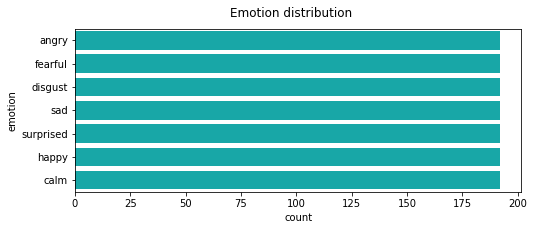

In [576]:
mask = df.emotion == 'neutral'
df = df[~mask]
f, ax = plt.subplots(figsize=(8, 3))
sns.countplot(y="emotion", data=df, color="c")
plt.suptitle('Emotion distribution');

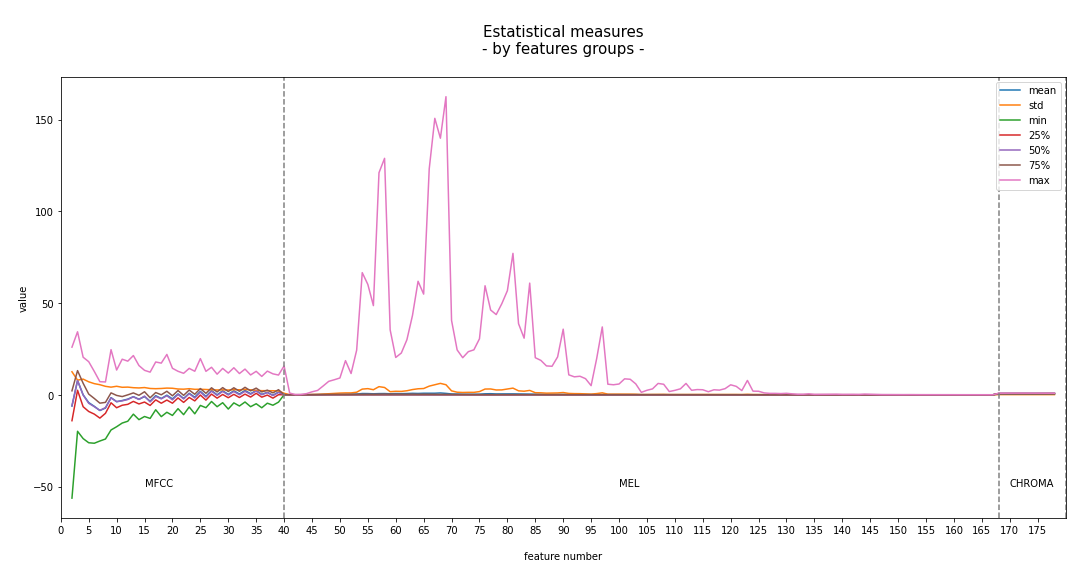

In [577]:

plt.figure(figsize=(15,8))

descr = df.describe()
for n in range(descr.iloc[1:,2:-2].shape[0]):
        sns.lineplot(x=descr.columns[2:-2], y=descr.iloc[n+1,2:-2], legend='auto'); 

features_dict = {
    'MFCC':[(15,-50),40, (3,41)],
    'MEL':[(100,-50),168, (41,169)],
    'CHROMA':[(170,-50), 180, (169,179)],
}
for k, v in features_dict.items():
    plt.axvline(x=v[1], color='grey', linestyle='--', label=None)
    plt.annotate(k,v[0])

plt.xticks(np.arange(0,180,5))
plt.xlim(0,180)
plt.legend(df.describe().index[1:], loc='upper right')
plt.xlabel('\nfeature number')
plt.ylabel('\nvalue')
plt.title('\nEstatistical measures\n- by features groups -\n', size=15)
plt.tight_layout()

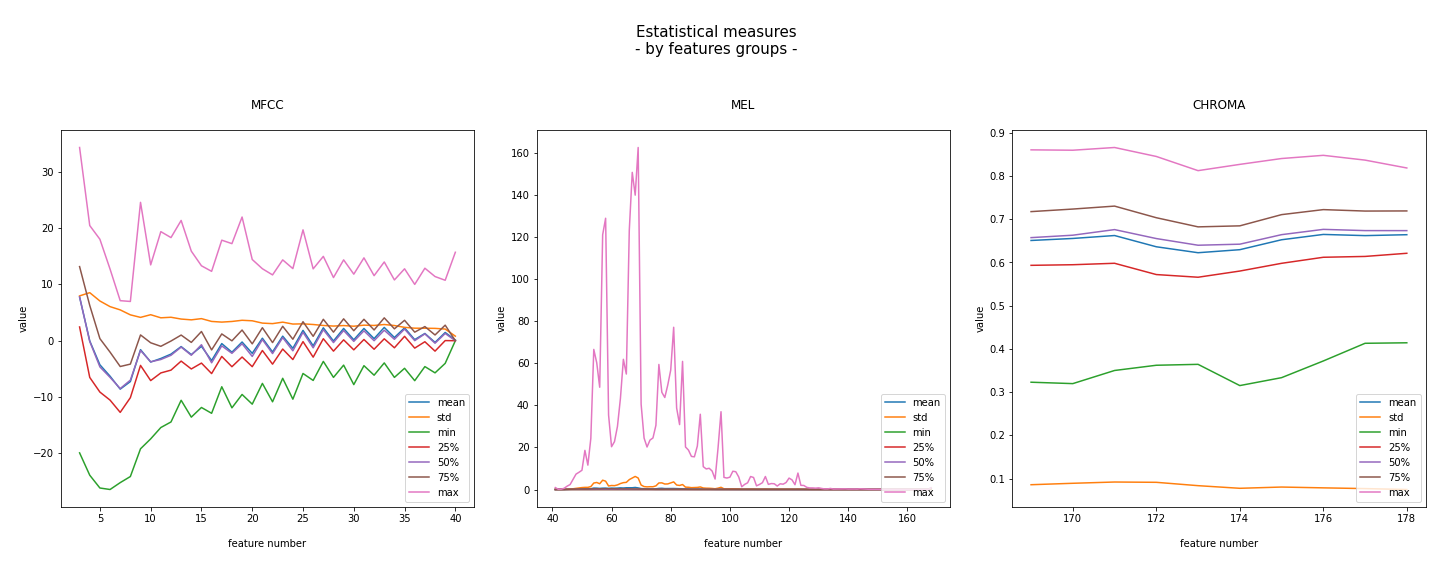

In [578]:
features_interval = [(3,41),(41,169),(169,179)]
features_name = ['MFCC','MEL','CHROMA']
# plt.figure(figsize=(12,8))
rows = 1
columns = 3

fig, ax = plt.subplots(nrows=rows, ncols=columns,  figsize=(20,8))
# ax = ax.ravel()

for i, chart in enumerate(ax):
        a,b = features_interval[i]
        for n in range(descr.iloc[1:,a:b].shape[0]):
          sns.lineplot(ax=chart, x=descr.columns[a:b], y=descr.iloc[n+1,a:b]);
          chart.legend(df.describe().index[1:],loc="lower right");
          chart.set_title(f'\n{features_name[i]}\n')
          chart.set_xlabel('\nfeature number\n')
          chart.set_ylabel('\nvalue')

fig.suptitle('\nEstatistical measures\n- by features groups -\n', size=15)
plt.tight_layout()

In [571]:
# Save raw dataset
# df.to_csv('../data/voice_features_raw.csv', index=False)

<h4>Normalize data</h4>

In [579]:
### Normalize features 

scaler  =  MinMaxScaler()
X = scaler.fit_transform(features)

In [589]:
### Save normalized dataset with labels
# df.to_csv('../data/voice_features_normalized.csv', index=False)

<h4>Target encoder</h4>

In [581]:
### Encode emotions

lb = LabelEncoder()
Y = lb.fit_transform(emotions)
Y = to_categorical(Y)

print(Y.shape)
print(Y[0])

(1440, 8)
[1. 0. 0. 0. 0. 0. 0. 0.]


In [582]:
# Create dataset
df = pd.concat([pd.DataFrame(X), pd.DataFrame(Y, columns=lb.classes_)], axis=1)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,angry,calm,disgust,fearful,happy,neutral,sad,surprised
0,0.562565,0.384038,0.621812,0.431466,0.301129,0.464524,0.444735,0.438099,0.390474,0.417503,0.318004,0.282440,0.333856,0.172324,0.242643,0.267703,0.407864,0.058209,0.193253,0.236576,0.247635,0.377080,0.366098,0.346391,0.274734,0.190133,0.263980,0.096395,0.436252,0.450413,0.571612,0.439927,0.300392,0.288554,0.348895,0.458068,0.431844,0.397619,0.266818,0.419400,0.000001,0.000101,0.001373,0.000894,0.001521,0.009528,0.017948,0.053703,0.070772,0.015914,0.013057,0.021255,0.015575,0.003222,0.001142,0.004508,0.009566,0.003290,0.003089,0.004429,0.006218,0.013463,0.017248,0.011040,0.002193,0.003975,0.002038,0.002427,0.003244,0.000984,0.001783,0.006498,0.007439,0.004354,0.009107,0.008849,0.003763,0.004463,0.000654,0.000588,0.000302,0.000762,0.002240,0.001452,0.001125,0.004930,0.007432,0.003116,0.002224,0.003328,0.005220,0.010626,0.005707,0.001412,0.000789,0.002795,0.000759,0.000954,0.005612,0.001787,0.001216,0.001747,0.001661,0.002179,0.002808,0.002652,0.002349,0.004695,0.001124,0.002530,0.006745,0.007552,0.001729,0.000977,0.002100,0.001814,0.003161,0.002666,0.005106,0.005421,0.004680,0.007941,0.020816,0.005629,0.042029,0.021060,0.019832,0.023692,0.020583,0.019128,0.009713,0.013265,0.012019,0.010536,0.002995,0.006228,0.009855,0.006392,0.007023,0.005316,0.006227,0.004754,0.004258,0.010574,0.002659,0.004524,0.016128,0.032893,0.071560,0.111866,0.189327,0.120528,0.047189,0.145828,0.115892,0.188070,0.261593,0.377078,0.282135,0.138083,0.060959,0.055457,0.042727,0.059008,0.086752,0.110460,0.186098,0.090325,0.39971,0.357987,0.397585,0.438458,0.384390,0.489953,0.438796,0.406293,0.463329,0.452571,0.498538,0.404362,0.590987,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.546871,0.417574,0.596210,0.461148,0.468564,0.387311,0.296866,0.349285,0.494042,0.463705,0.145791,0.227369,0.477595,0.130769,0.244952,0.313035,0.275866,0.205500,0.252109,0.175108,0.420068,0.421076,0.558429,0.523255,0.482382,0.463822,0.364160,0.295234,0.352585,0.221949,0.365028,0.269324,0.267364,0.271952,0.305807,0.356118,0.386122,0.355436,0.301441,0.327809,0.000002,0.000043,0.000480,0.000427,0.000658,0.002770,0.017740,0.034977,0.040065,0.084168,0.056725,0.012767,0.016336,0.007338,0.001406,0.000792,0.001057,0.001065,0.002014,0.009884,0.067496,0.038197,0.008720,0.003042,0.000740,0.001058,0.000369,0.000121,0.000147,0.000073,0.000747,0.002574,0.002127,0.001964,0.000640,0.000190,0.000100,0.000112,0.000058,0.000043,0.000049,0.000082,0.000135,0.000093,0.000047,0.000128,0.000171,0.000222,0.000355,0.000268,0.000182,0.000428,0.000611,0.000433,0.000540,0.000569,0.000095,0.000065,0.000772,0.001074,0.000769,0.000467,0.000405,0.000382,0.001968,0.000984,0.000901,0.000293,0.000091,0.000200,0.000475,0.001004,0.000167,0.000191,0.000371,0.000804,0.002107,0.000305,0.000642,0.000330,0.000084,0.000094,0.000237,0.000132,0.000291,0.000494,0.000731,0.000770,0.000725,0.000693,0.000807,0.001881,0.005549,0.004431,0.001340,0.001327,0.000662,0.000534,0.000304,0.000522,0.001326,0.001778,0.002594,0.004358,0.002542,0.003824,0.006618,0.010165,0.014112,0.018973,0.027923,0.022139,0.022360,0.118438,0.076928,0.114889,0.176758,0.135227,0.088137,0.058980,0.048906,0.048279,0.031982,0.033538,0.040729,0.059162,0.065070,0.047323,0.38830,0.344066,0.291322,0.210113,0.096817,0.096021,0.179112,0.182291,0.210175,0.308362,0.363440,0.295259,0.437237,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.84

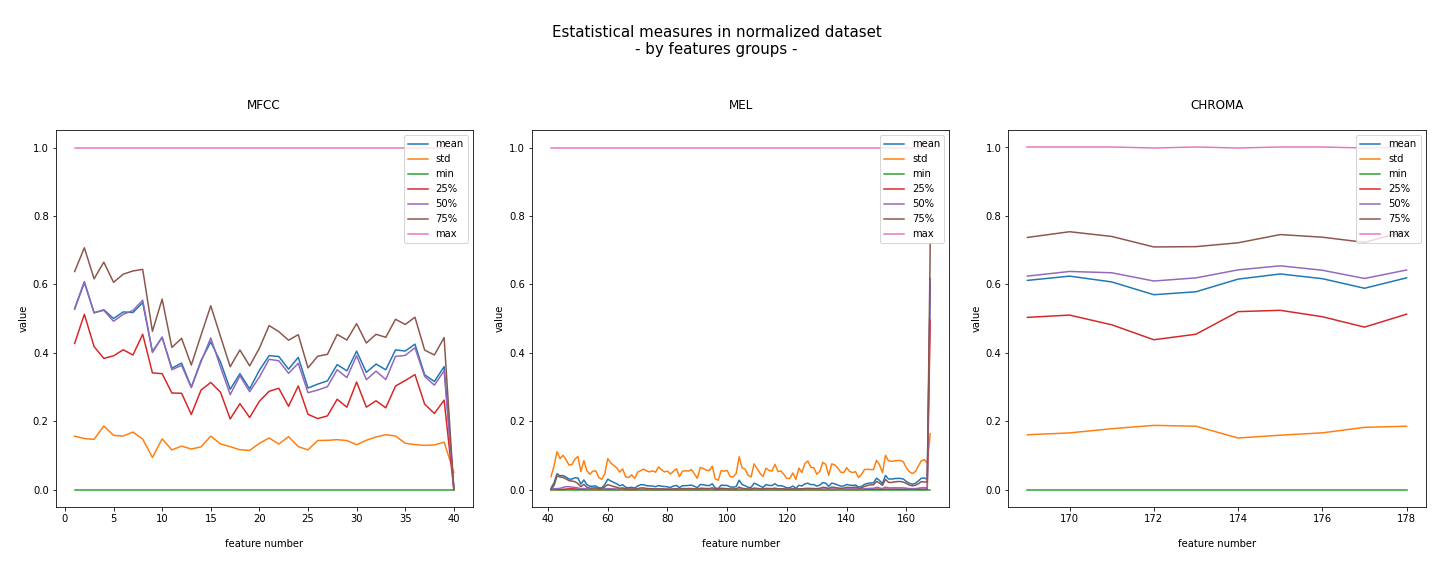

In [590]:
descr = df.describe()
features_interval = [(1,41),(41,169),(169,179)]
features_name = ['MFCC','MEL','CHROMA']
# plt.figure(figsize=(12,8))
rows = 1
columns = 3

fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(20,8))
# ax = ax.ravel()

for i, chart in enumerate(ax):
        a,b = features_interval[i]
        for n in range(descr.iloc[1:,a:b].shape[0]):
          sns.lineplot(ax=chart, x=descr.columns[a:b], y=descr.iloc[n+1,a:b]);
          chart.legend(df.describe().index[1:],loc="upper right");
          chart.set_title(f'\n{features_name[i]}\n')
          chart.set_xlabel('\nfeature number\n')
          chart.set_ylabel('\nvalue')

fig.suptitle('\nEstatistical measures in normalized dataset\n- by features groups -\n', size=15)
plt.tight_layout()

In [ ]:
# Save normalized and encoded dataset
# df.to_csv('../data/voice_features_normalized_encoded.csv', index=False)

<hr>
<br><br>
<div align=right>
    <font size=2>
        Julio Valim &emsp;
    </font>
    <br>
    <font size=1>
        <a href='https://www.linkedin.com/in/juliovalim'>contato /in</a>&emsp;&emsp;
    </font>
</div>